<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Hard-coded-agents-championship" data-toc-modified-id="Hard-coded-agents-championship-1">Hard coded agents championship</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1">Imports</a></span></li><li><span><a href="#Agents" data-toc-modified-id="Agents-1.2">Agents</a></span><ul class="toc-item"><li><span><a href="#Random" data-toc-modified-id="Random-1.2.1">Random</a></span></li><li><span><a href="#Random-plus" data-toc-modified-id="Random-plus-1.2.2">Random plus</a></span></li><li><span><a href="#Greedy" data-toc-modified-id="Greedy-1.2.3">Greedy</a></span></li><li><span><a href="#Risk-averse-goose" data-toc-modified-id="Risk-averse-goose-1.2.4">Risk averse goose</a></span></li></ul></li><li><span><a href="#Championship" data-toc-modified-id="Championship-1.3">Championship</a></span><ul class="toc-item"><li><span><a href="#Code" data-toc-modified-id="Code-1.3.1">Code</a></span></li><li><span><a href="#Elo-ranking" data-toc-modified-id="Elo-ranking-1.3.2">Elo ranking</a></span></li><li><span><a href="#Finding-the-optimal-speed-factor-K-for-Elo-ranking" data-toc-modified-id="Finding-the-optimal-speed-factor-K-for-Elo-ranking-1.3.3">Finding the optimal speed factor K for Elo ranking</a></span></li><li><span><a href="#Matches" data-toc-modified-id="Matches-1.3.4">Matches</a></span></li></ul></li></ul></li></ul></div>

# Hard coded agents championship

## Imports

In [1]:
import os
import kaggle_environments
from kaggle_environments import make
from kaggle_environments import evaluate
from kaggle_environments.envs.hungry_geese.hungry_geese import Action
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import pandas as pd
from tqdm.notebook import tqdm

%config Completer.use_jedi = False

Loading environment football failed: No module named 'gfootball'


In [2]:
plt.plot()
plt.close('all')
plt.rcParams["figure.figsize"] = (30, 5)  
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 16

## Agents

### Random

https://github.com/Kaggle/kaggle-environments/blob/master/kaggle_environments/envs/hungry_geese/hungry_geese.py#L117

```python
def random_agent():
    return choice([action for action in Action]).name
```

### Random plus

This is a random bot but does not make opposite actions.

In [3]:
class RandomPlus:
    def __init__(self):
        self.last_action = None
        
    def __call__(self):
        if self.last_action is not None:
            options = [action for action in Action if action != self.last_action.opposite()]
        else:
            options = [action for action in Action if action]
            
        action = random.choice(options)
        self.last_action = action
        return action.name

In [4]:
cached_random_plus_agents = {}

In [5]:
def random_plus_agent(obs, config):
    index = obs["index"]
    if index not in cached_random_plus_agents:
        cached_random_plus_agents[index] = RandomPlus()
    return cached_random_plus_agents[index]()

### Greedy

https://github.com/Kaggle/kaggle-environments/blob/master/kaggle_environments/envs/hungry_geese/hungry_geese.py#L121

- Don't move adjacent to any heads
- Don't move into any bodies
- Move to the closest food

```python
class GreedyAgent:
    def __init__(self, configuration: Configuration):
        self.configuration = configuration
        self.last_action = None

    def __call__(self, observation: Observation):
        rows, columns = self.configuration.rows, self.configuration.columns

        food = observation.food
        geese = observation.geese
        opponents = [
            goose
            for index, goose in enumerate(geese)
            if index != observation.index and len(goose) > 0
        ]

        # Don't move adjacent to any heads
        head_adjacent_positions = {
            opponent_head_adjacent
            for opponent in opponents
            for opponent_head in [opponent[0]]
            for opponent_head_adjacent in adjacent_positions(opponent_head, columns, rows)
        }
        # Don't move into any bodies
        bodies = {position for goose in geese for position in goose}

        # Move to the closest food
        position = geese[observation.index][0]
        actions = {
            action: min_distance(new_position, food, columns)
            for action in Action
            for new_position in [translate(position, action, columns, rows)]
            if (
                new_position not in head_adjacent_positions and
                new_position not in bodies and
                (self.last_action is None or action != self.last_action.opposite())
            )
        }

        action = min(actions, key=actions.get) if any(actions) else choice([action for action in Action])
        self.last_action = action
        return action.name
```

### Risk averse goose

https://www.kaggle.com/ilialar/risk-averse-greedy-goose

This notebook proposes a simple greedy straightforward solution. At each step:
- Mark all cells that can be dangerous on the next step as obstacles
- Find the shortest route to the nearest food item
- Make one step toward this food
- Repeat

## Championship

### Code

In [23]:
def sample_agent_keys(agents):
    if isinstance(agents, dict):
        keys = list(agents.keys())
    else:
        keys = agents
    while 1:
        samples = np.random.choice(keys, size=4)
        if len(np.unique(samples)) > 1:
            break
    return samples

### Elo ranking

In [18]:
class EloRanking():
    def __init__(self, agents, k=8, verbose=False):
        """
        Computes Elo ranking
        
        Parameters
        -----------
        agents : list of str
            Name of the agents that will be used in the ranking
        k : float
            Elo speed constant, it seems that 8 is ok for our problem
        verbose : bool
        """
        self.ranking = {agent: [1000] for agent in agents}
        self.k = k
        self.verbose = verbose
    
    def add_match(self, agents, scores):
        updates = self._compute_updates(agents, scores)
        if self.verbose: print(updates)
        self._apply_updates(updates)
        
    def _compute_updates(self, agents, scores):
        updates = {agent:0 for agent in np.unique(agents)}
        for idx, agent1 in enumerate(agents):
            score1 = scores[idx]
            for agent2, score2 in zip(agents[idx+1:], scores[idx+1:]):
                if agent1 == agent2:
                    continue
                result = elo_result(score1, score2)
                update = self.k*(result - elo_expectation(self.ranking[agent1][-1], self.ranking[agent2][-1]))
                updates[agent1] += update
                updates[agent2] -= update
                self.verbose: print(agent1, score1, agent2, score2, elo_result(score1, score2))
        return updates
    
    def _apply_updates(self, updates):
        for agent in self.ranking:
            if agent in updates:
                self.ranking[agent].append(self.ranking[agent][-1] + updates[agent])
            else:
                self.ranking[agent].append(self.ranking[agent][-1])
                
    def plot(self):
        for agent, ranking in self.ranking.items():
            #plt.plot(ranking, label=agent, marker='o')
            plt.plot(ranking, label=agent)
        plt.legend(loc=0)
        plt.grid(axis='y')
        
    def summary(self):
        agents = list(self.ranking.keys())
        ranking = [int(self.ranking[agent][-1]) for agent in agents]
        summary = pd.DataFrame(dict(ranking=ranking), index=agents)
        return summary.sort_values('ranking', ascending=False)
        
                
def elo_result(score1, score2):
    if score1 > score2:
        return 1
    elif score1 == score2:
        return 0.5
    else:
        return 0
    
def elo_expectation(ranking1, ranking2):
    return 1./(1+10**((ranking2 - ranking1)/400))

### Finding the optimal speed factor K for Elo ranking

In [46]:
sampled_keys = ['random', 'random', 'random_plus', 'random_plus']

rets = evaluate("hungry_geese", agents=[agents[key] for key in sampled_keys], num_episodes=1000)

On chess the recommend value for k is 32. However we can see below that the metrics are very noisy if using that value.
However smaller k is used for players with higher level. 

https://en.wikipedia.org/wiki/Elo_rating_system

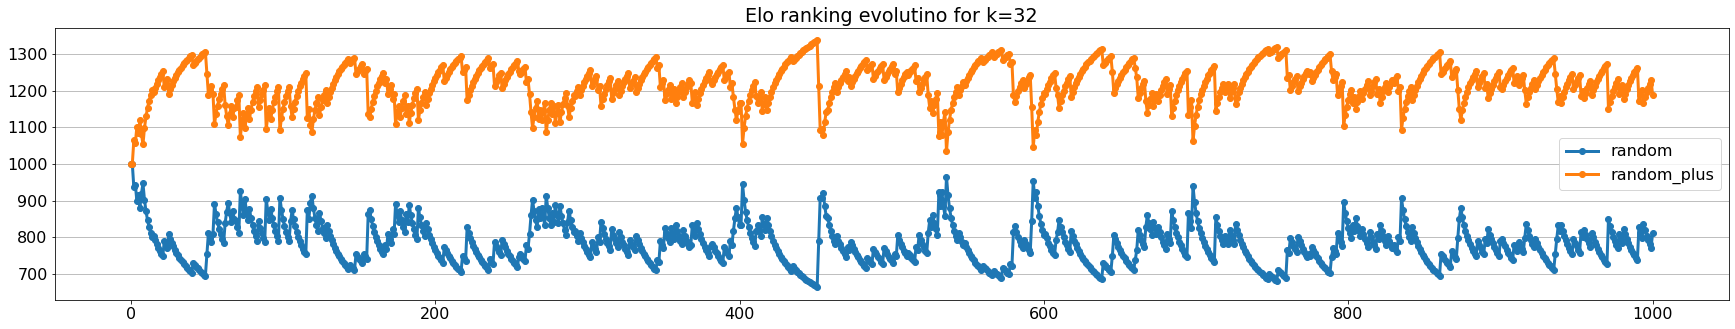

In [66]:
k = 32
elo_ranking = EloRanking(np.unique(sampled_keys), k=k)

for ret in rets:
    elo_ranking.add_match(sampled_keys, ret)
elo_ranking.plot()
plt.title('Elo ranking evolutino for k=%i' % k);

In the other hand if we use k=1 we get very stable scores, but it takes more than 600 matches to reach an equilibrium with a difference of around 400 points between agents. Let's see if we can get faster
convergence without too much noise.

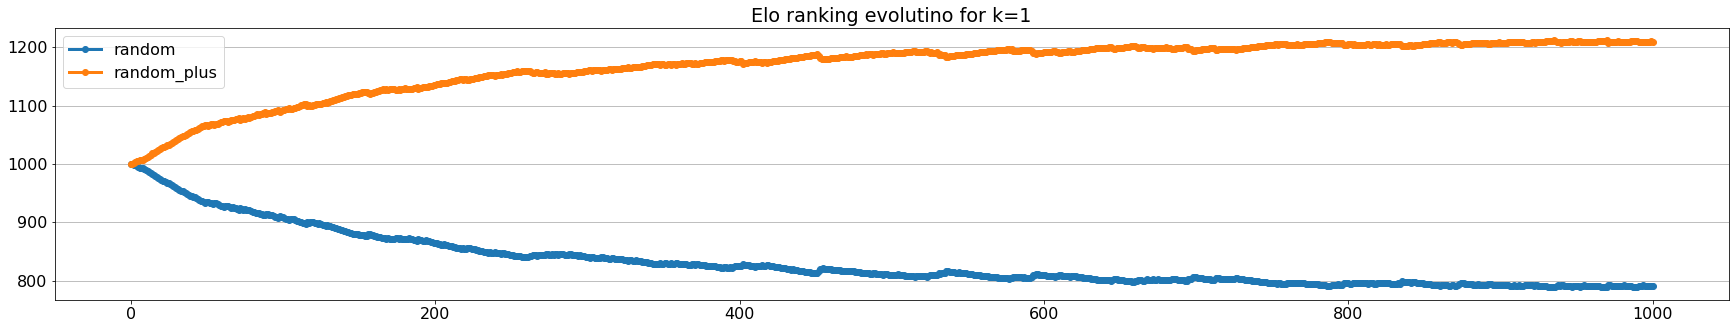

In [68]:
k = 1
elo_ranking = EloRanking(np.unique(sampled_keys), k=k)

for ret in rets:
    elo_ranking.add_match(sampled_keys, ret)
elo_ranking.plot()
plt.title('Elo ranking evolutino for k=%i' % k);

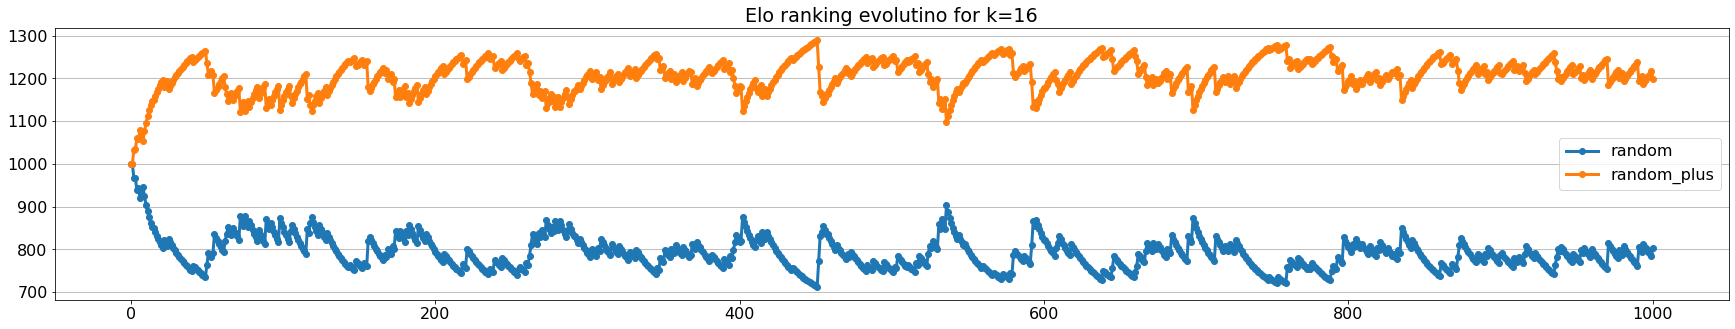

In [65]:
k = 16
elo_ranking = EloRanking(np.unique(sampled_keys), k=k)

for ret in rets:
    elo_ranking.add_match(sampled_keys, ret)
elo_ranking.plot()
plt.title('Elo ranking evolutino for k=%i' % k);

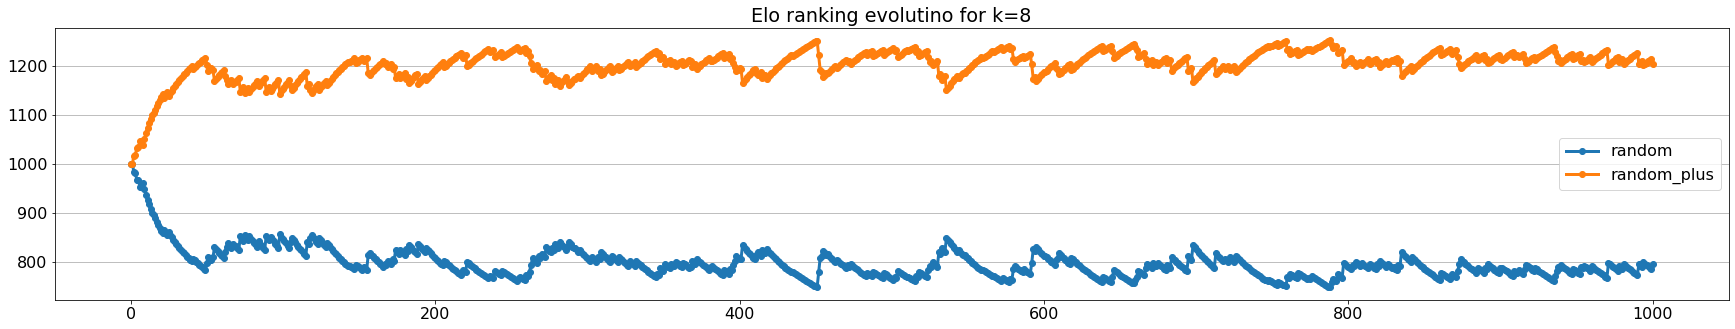

In [64]:
k = 8
elo_ranking = EloRanking(np.unique(sampled_keys), k=k)

for ret in rets:
    elo_ranking.add_match(sampled_keys, ret)
elo_ranking.plot()
plt.title('Elo ranking evolutino for k=%i' % k);

8 might be a good compromise value, it seems to reach convergence around 50 matches and it is not very noisy. K=4 seems to be very slow.

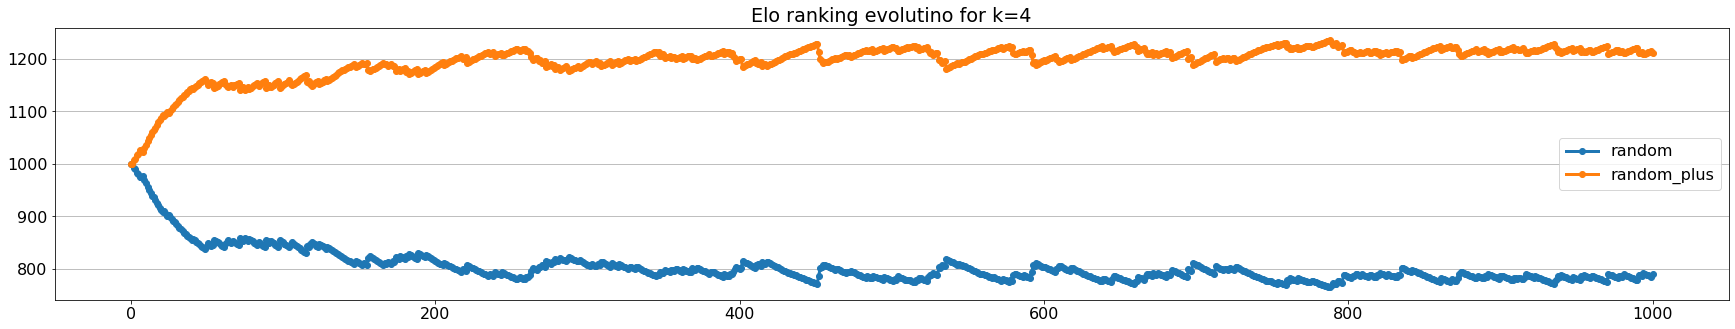

In [63]:
k = 4
elo_ranking = EloRanking(np.unique(sampled_keys), k=k)

for ret in rets:
    elo_ranking.add_match(sampled_keys, ret)
elo_ranking.plot()
plt.title('Elo ranking evolutino for k=%i' % k);

### Matches

In [8]:
agents = {
    'random': 'random',
    'random_plus': random_plus_agent,
    'greedy': 'greedy',
    'risk_averse_goose': '../forum/agents/risk_averse_goose.py',
    'goose_on_a_healthy_diet': '../forum/agents/goose_on_a_healthy_diet.py'
}

In [9]:
matches_results = []
matches_agents = []

In [10]:
num_episodes = 50
for _ in tqdm(range(num_episodes)):
    sampled_keys = sample_agent_keys(agents)
    matches_results.extend(evaluate("hungry_geese", agents=[agents[key] for key in sampled_keys], num_episodes=1))
    matches_agents.append(sampled_keys)

  0%|          | 0/50 [00:00<?, ?it/s]

In [13]:
num_episodes = 200
for _ in tqdm(range(num_episodes)):
    sampled_keys = sample_agent_keys(agents)
    matches_results.extend(evaluate("hungry_geese", agents=[agents[key] for key in sampled_keys], num_episodes=1))
    matches_agents.append(sampled_keys)

  0%|          | 0/200 [00:00<?, ?it/s]

In [15]:
num_episodes = 1000
for _ in tqdm(range(num_episodes)):
    sampled_keys = sample_agent_keys(agents)
    matches_results.extend(evaluate("hungry_geese", agents=[agents[key] for key in sampled_keys], num_episodes=1))
    matches_agents.append(sampled_keys)

  0%|          | 0/1000 [00:00<?, ?it/s]

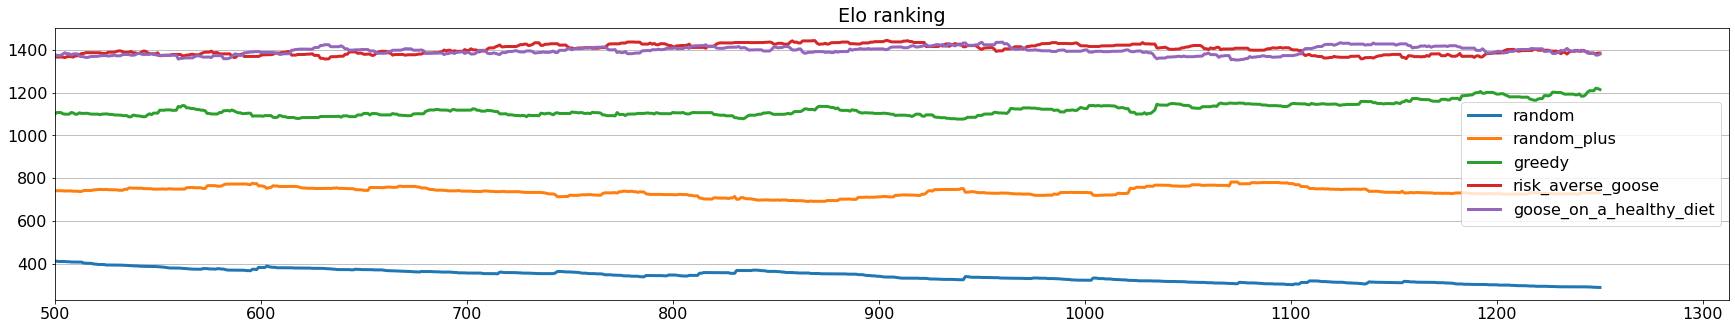

,ranking
risk_averse_goose,1385
goose_on_a_healthy_diet,1380
greedy,1214
random_plus,730
random,287


In [19]:
elo_ranking = EloRanking(list(agents.keys()))
for match_agents, match_results in zip(matches_agents, matches_results):
    elo_ranking.add_match(match_agents, match_results)
elo_ranking.plot()
plt.xlim(left=500)
plt.title('Elo ranking'); plt.show();
elo_ranking.summary()

In [24]:
num_episodes = 100
for _ in tqdm(range(num_episodes)):
    sampled_keys = sample_agent_keys(['greedy', 'risk_averse_goose', 'goose_on_a_healthy_diet'])
    matches_results.extend(evaluate("hungry_geese", agents=[agents[key] for key in sampled_keys], num_episodes=1))
    matches_agents.append(sampled_keys)

  0%|          | 0/100 [00:00<?, ?it/s]

In [26]:
num_episodes = 500
for _ in tqdm(range(num_episodes)):
    sampled_keys = sample_agent_keys(['greedy', 'risk_averse_goose', 'goose_on_a_healthy_diet'])
    matches_results.extend(evaluate("hungry_geese", agents=[agents[key] for key in sampled_keys], num_episodes=1))
    matches_agents.append(sampled_keys)

  0%|          | 0/500 [00:00<?, ?it/s]

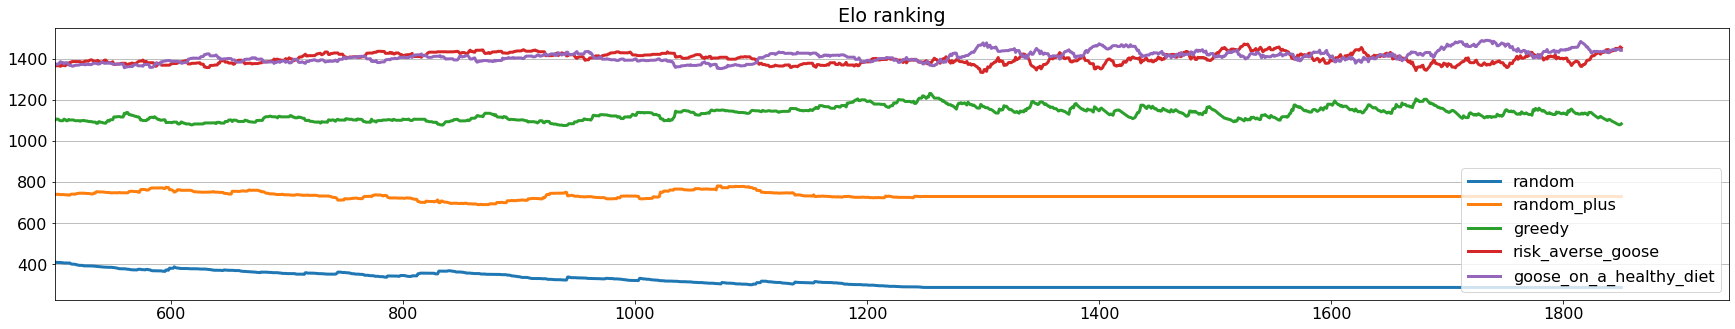

,ranking
risk_averse_goose,1454
goose_on_a_healthy_diet,1442
greedy,1084
random_plus,730
random,287


In [27]:
elo_ranking = EloRanking(list(agents.keys()))
for match_agents, match_results in zip(matches_agents, matches_results):
    elo_ranking.add_match(match_agents, match_results)
elo_ranking.plot()
plt.xlim(left=500)
plt.title('Elo ranking'); plt.show();
elo_ranking.summary()

Doing matches between the best agents does not change the ranking too much.

TODO: 
- study how added agents work
- compute elo ranking from the agents that play each match and the ranking of each match.
- Create a better random agent that does not change direction, and compare with default one